In [1]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

%matplotlib inline

## 1. MOG on MNIST

In [3]:
with open('./plots/static_mnist_mog_lossvalues_test_per_epoch.json', 'r') as f:
    data = json.load(f)

data.keys()

dict_keys(['model_name', 'test_loss', 'test_re', 'test_kl', 'number_epochs', 'prior', 'pseudo_components', 'learning_rate', 'hidden_components'])

**Collect test losses into a data frame**

In [4]:
losses = {
    'test_loss': data['test_loss'],
    'test_re': data['test_re'],
    'test_kl': data['test_kl'],
}

df = pd.DataFrame(losses)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   test_loss  2000 non-null   float64
 1   test_re    2000 non-null   float64
 2   test_kl    2000 non-null   float64
dtypes: float64(3)
memory usage: 47.0 KB


In [5]:
df.head(5)

,test_loss,test_re,test_kl
0,162.230707,-86.629384,75.601323
1,123.824212,-69.600395,54.223816
2,108.814600,-62.985867,45.828734
3,100.480475,-59.932117,40.548357
4,86.013045,-57.772879,28.240165


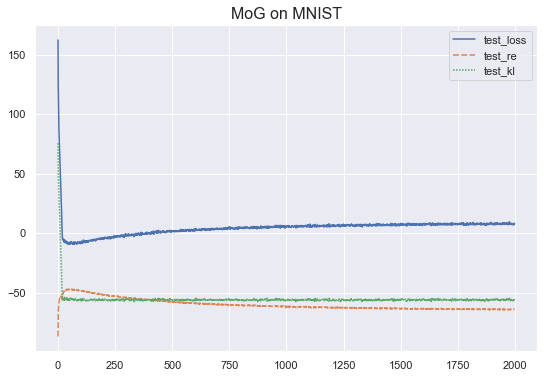

In [14]:
fig = plt.figure(figsize=(9, 6))
ax = fig.subplots()
sns.lineplot(data=df, ax=ax)
ax.set_title('MoG on MNIST', fontsize=16)
fig.savefig('./plots/mog_mnist.png')